In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Loading the data

In [2]:
df = pd.read_parquet('../Data/features_tfidf_removed_categories.parquet.gz')
df.head()

,bagsandluggage,beautyandhealth,capsandhats,drinkware,hoodiesandjackets,kidsapparel,petsupplies,sportsandfitness
CustomerID,,,,,,,,
12347,0.568189,0.000000,0.388631,0.463974,0.366188,0.215148,0.0,0.361210
12348,0.000000,0.000000,0.000000,0.636778,0.000000,0.590556,0.0,0.495740
12350,0.000000,0.000000,0.974051,0.000000,0.000000,0.000000,0.0,0.226331
12356,0.203496,0.436919,0.000000,0.498515,0.393450,0.462330,0.0,0.388101
12359,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.0,0.000000


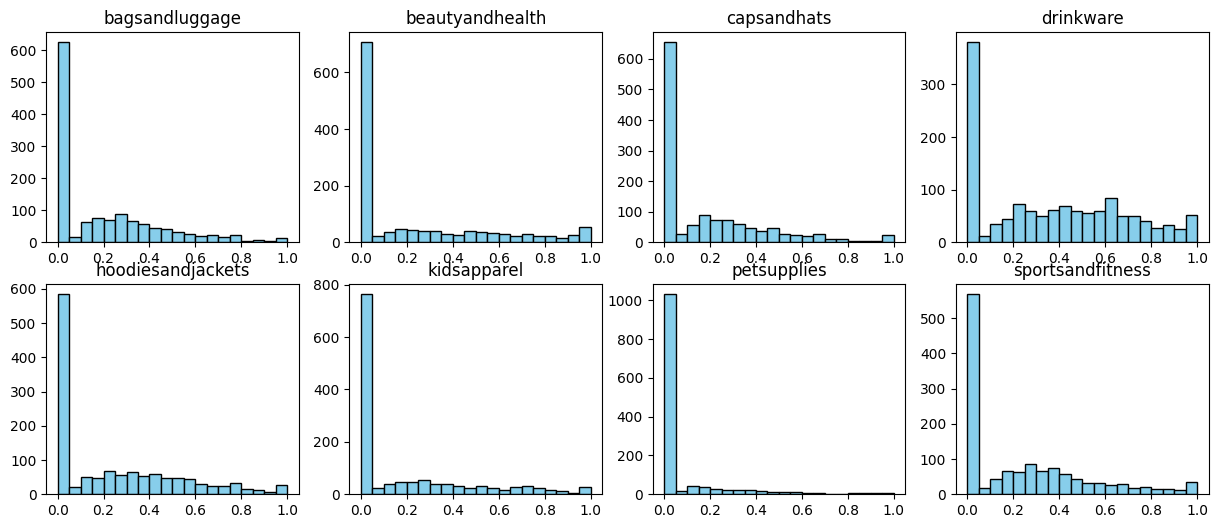

In [3]:
# Creating a 2x5 subplot grid
fig, axs = plt.subplots(2, 4, figsize=(15, 6))

# Flatten the axs array to make it easier to iterate
axs = axs.flatten()

# Plot histograms
for i, column in enumerate(df.columns):
    axs[i].hist(df[column], bins=20, color='skyblue', edgecolor='black')
    axs[i].set_title(column)

# Mean scaling of the TF-IDF features

In [ ]:
# from sklearn.preprocessing import StandardScaler

# # Initialize the StandardScaler
# scaler = StandardScaler()

# # Fit and transform the data simultaneously
# X = scaler.fit_transform(df.to_numpy())

# NMF

In [4]:
from sklearn.decomposition import NMF

X = np.log(df.to_numpy() + 1)
nmf = NMF(max_iter=10000)
U = nmf.fit_transform(X)
V = nmf.components_.T

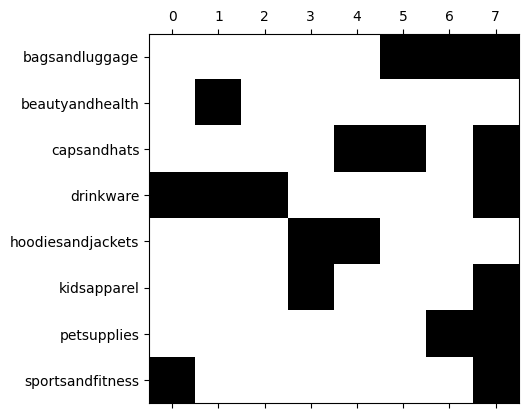

In [5]:
features = df.columns

fig, ax = plt.subplots()
ax.spy(V)
ax.set_xticks(range(len(features)))
ax.set_yticks(range(len(features)))
ax.set_yticklabels(features);

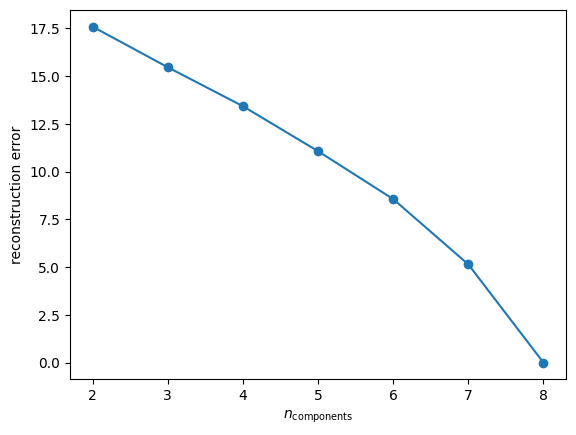

In [6]:
n_components = list(range(2, len(features) + 1))
errors = []
for n_component in n_components:
    nmf_ = NMF(n_component, max_iter=10000)
    nmf_.fit(X)
    errors.append(nmf_.reconstruction_err_)
plt.plot(n_components, errors, '-o')
plt.xlabel(r'$n_\text{components}$')
plt.ylabel('reconstruction error');

# PCA

In [ ]:
# from sklearn.decomposition import PCA

# # Initialize PCA
# pca = PCA()

# # Fit PCA to the mean-scaled data
# pca.fit(X)

# plt.plot(list(range(1, df.shape[1] + 1)), np.cumsum(pca.explained_variance_ratio_), marker='o')
# plt.xlabel('Number of Components')
# plt.ylabel('Cumulative Explained Variance')

NOTE: Keep 7 principal components.

In [ ]:
# pca = PCA(n_components=7)

# # Fit PCA to the mean-scaled data and transform it
# X = pca.fit_transform(X)

# Clustering

### 1. K-Means

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

# Store the evaluation scores
inertia = []
silhouette_scores = []
ch_score = []
davies_bouldin_scores = []

# Try several K number of clusters
k_values = range(3, 15)
for k in k_values:
    print(f"k = {k}")

    # Storing the raw scores for each model
    inertia_samples = []
    silhouette_score_samples = []
    ch_score_samples = []
    db_score_samples = []

    # Cluster 15 times to get the average evaluation scores later on
    for _ in range(15):
        print(f"\tj = {_}")
        
        # Clustering Step
        kmeans = KMeans(n_clusters=k, 
                        init='k-means++', 
                        algorithm='elkan',
                        n_init=10)
        kmeans.fit(X)

        # Getting the cluster labels
        labels = kmeans.labels_

        # Get the Inertia (for elbow method)
        inertia_samples.append(kmeans.inertia_)
    
        # Get the Silhouette score
        silhouette_score_samples.append(silhouette_score(X, labels))

        # Calinski-Harabasz score 
        ch_score_samples.append(calinski_harabasz_score(X, labels))
        
        # Davies Bouldin Score
        db_score_samples.append(davies_bouldin_score(X, labels))


    # Mean of the metrics
    inertia.append(inertia_samples)
    silhouette_scores.append(silhouette_score_samples)
    ch_score.append(ch_score_samples)
    davies_bouldin_scores.append(db_score_samples)

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(10,10))

axs[0, 0].plot(k_values, np.mean(inertia, axis=1), linestyle='-', marker='o')
axs[0, 0].errorbar(k_values, np.mean(inertia, axis=1), yerr = np.std(inertia, axis=1, ddof=1), fmt ='none')
axs[0, 0].set_title('Elbow Method')

axs[0, 1].plot(k_values, np.mean(silhouette_scores, axis=1), linestyle='-', marker='o')
axs[0, 1].errorbar(k_values, np.mean(silhouette_scores, axis=1), yerr = np.std(silhouette_scores, axis=1, ddof=1), fmt ='none')
axs[0, 1].set_title('Silhouette Score (ideal: higher than .5)')

axs[1, 0].plot(k_values, np.mean(ch_score, axis=1), linestyle='-', marker='o')
axs[1, 0].errorbar(k_values, np.mean(ch_score, axis=1), yerr = np.std(ch_score, axis=1, ddof=1), fmt ='none')
axs[1, 0].set_title('Calinski-Harabasz Score (ideal: large score)')

axs[1, 1].plot(k_values, np.mean(davies_bouldin_scores, axis=1), linestyle='-', marker='o')
axs[1, 1].errorbar(k_values, np.mean(davies_bouldin_scores, axis=1), yerr = np.std(davies_bouldin_scores, axis=1, ddof=1), fmt ='none')
axs[1, 1].set_title('Davies Bouldin Score (ideal: close to zero)')